In [1]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]

In [2]:
training_data_file = open("./dataset/pascal_voc_training_data.txt", "r")
for i, line in enumerate(training_data_file):
    if i >5:
        break
    line = line.strip()
    print(line)

000005.jpg 263 211 324 339 8 165 264 253 372 8 5 244 67 374 8 241 194 295 299 8 277 186 312 220 8
000007.jpg 141 50 500 330 6
000009.jpg 69 172 270 330 12 150 141 229 284 14 285 201 327 331 14 258 198 297 329 14
000012.jpg 156 97 351 270 6
000016.jpg 92 72 305 473 1
000017.jpg 185 62 279 199 14 90 78 403 336 12


In [3]:
import tensorflow as tf
import numpy as np
import cv2

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Select GPU number 1
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:
# common params
IMAGE_SIZE = 600
BATCH_SIZE = 8
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20

# dataset params
DATA_PATH = './dataset/pascal_voc_training_data.txt'
IMAGE_DIR = './dataset/VOCdevkit_train/VOC2007/JPEGImages/'
OUT_DIR = './dataset/gen2/photo/'

# model params
CELL_SIZE = 7
BOXES_PER_CELL = 2
OBJECT_SCALE = 1
NOOBJECT_SCALE = 0.5
CLASS_SCALE = 1
COORD_SCALE = 5

# training params
LEARNING_RATE = 1e-4
EPOCHS = 3

In [6]:
import imageio
import imgaug as ia
%matplotlib inline

In [14]:
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

class DatasetGenerator:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline ready to be fed into a model.
    - Reshapes images into 448 x 448
    - converts [0 1] to [-1 1]
    - shuffles the input
    - builds batches
    """

    def __init__(self):
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        # filling the record_list
        input_file = open(DATA_PATH, 'r')
        self.fp = open(OUT_DIR+"pascal_voc_training_data.txt", "a")

        for line in input_file:
            line = line.strip()
            ss = line.split(' ')
            self.image_names.append(ss[0])

            self.record_list.append([float(num) for num in ss[1:]])

            self.object_num_list.append(min(len(self.record_list[-1])//5, MAX_OBJECTS_PER_IMAGE))
            if len(self.record_list[-1]) < MAX_OBJECTS_PER_IMAGE*5:
                self.record_list[-1] = self.record_list[-1] +\
                [0., 0., 0., 0., 0.]*\
                (MAX_OBJECTS_PER_IMAGE-len(self.record_list[-1])//5)
            elif len(self.record_list[-1]) > MAX_OBJECTS_PER_IMAGE*5:
                self.record_list[-1] = self.record_list[-1][:MAX_OBJECTS_PER_IMAGE*5]

    def _data_preprocess(self, image_name, raw_labels, object_num):
        #print(raw_labels)
        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]
        xmin = xmin.numpy()
        ymin = ymin.numpy()
        xmax = xmax.numpy()
        ymax = ymax.numpy()
        class_num = class_num.numpy()
        
        image = imageio.imread(IMAGE_DIR+image_name)

        b_list = []
        for i in range(object_num):
            b_list.append(BoundingBox(x1=xmin[i], x2=xmax[i], y1=ymin[i], y2=ymax[i]))
        bbs = BoundingBoxesOnImage(b_list, shape=image.shape)
        seq = iaa.Sequential([
            iaa.Fliplr(1),
            iaa.Rot90(1, keep_size=False),
            iaa.Rot90(1, keep_size=False),
            iaa.Rot90(1, keep_size=False)
        ])
        image_aug, bbs_aug = seq(image=image, bounding_boxes=bbs)
        
        image_before = bbs.draw_on_image(image, size=2)
#         ia.imshow(image_before)
        
        #ia.imshow(image_aug)
        
        
        imageio.imsave(OUT_DIR+image_name.split('.')[0]+'_flip_270.jpg', image_aug)
        self.fp.write('\n'+image_name.split('.')[0]+'_flip_270.jpg')
        #print(len(class_num))
        box_list = []
        for i in range(len(bbs.bounding_boxes)):
            after = bbs_aug.bounding_boxes[i]
            after_xmax = after.x1
            after_xmin = after.x2
            after_ymax = after.y1
            after_ymin = after.y2
            if after_xmax < after_xmin:
                tmp = after_xmax
                after_xmax = after_xmin
                after_xmin = tmp
            if after_ymax < after_ymin:
                tmp = after_ymax
                after_ymax = after_ymin
                after_ymin = tmp
            
            self.fp.write(' {} {} {} {} {}'.format(int(after_xmin), int(after_ymin), int(after_xmax), 
                                                   int(after_ymax), int(class_num[i])))
#             print(' {} {} {} {} {}'.format(int(after_xmin), int(after_ymin), int(after_xmax), 
#                                                         int(after_ymax), int(class_num[i])))
            box_list.append([after_xmin, after_xmax, after_ymin, after_ymax])
        bf_list = []
        for i in (box_list):
            bf_list.append(BoundingBox(x1=i[0], x2=i[1], y1=i[2], y2=i[3]))
            bbs = BoundingBoxesOnImage(bf_list, shape=image.shape)
        image_after = bbs.draw_on_image(image_aug, size=2)
#         ia.imshow(image_after)

    def generate(self):
        for i in range(len(self.image_names)):
            self._data_preprocess(self.image_names[i], np.array(self.record_list)[i], np.array(self.object_num_list)[i])
        self.fp.close()
        #return dataset

In [15]:
dg = DatasetGenerator()
dg.generate()
#dg.fp.close()

image_name


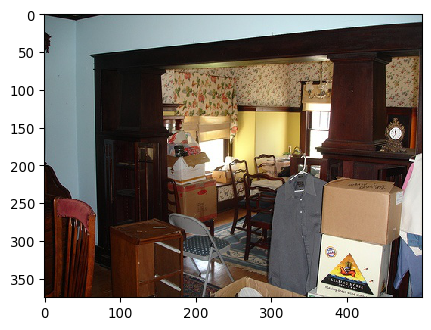

Augmented:


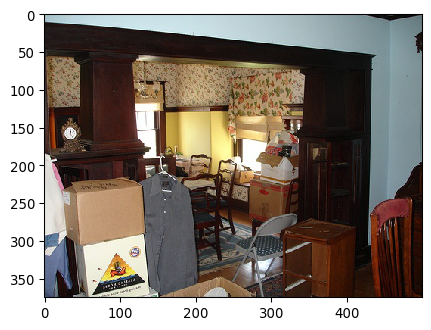

In [9]:
from imgaug import augmenters as iaa




image = imageio.imread(IMAGE_DIR+"000005.jpg")
print("image_name")
ia.imshow(image)

#images_aug = augmentation(images=image)

rotate = iaa.Fliplr(1)
image_aug = rotate.augment_image(image)

print("Augmented:")
ia.imshow(image_aug)

In [10]:
import helper as hp

In [11]:
hp.DATA_PATH

'./dataset/pascal_voc_training_data.txt'

In [12]:
k = hp.DatasetGeneratorXD()
k.generate()
threading.Thread(target = job, args = (i,))

TypeError: __init__() missing 3 required positional arguments: 'data_path', 'image_dir', and 'out_dir'